In [95]:
import steamreviews
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import col, udf, lit, udf
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
nlp = English()

spark = SparkSession.builder \
    .appName("Video Game Reviews") \
    .getOrCreate()

In [ ]:
request_params = dict()
request_params['language'] = 'english'

#Import the reviews from Steam
app_ids = [1145360, 462770, 237930, 107100]
steamreviews.download_reviews_for_app_id_batch(app_ids)

In [ ]:
# List all JSON files in a directory
json_files = [pos_json for pos_json in os.listdir('D:/Git/phase_4/data') if pos_json.endswith('.json')]

# Create an empty DataFrame to store all reviews
df = pd.DataFrame()

# Loop through all JSON files and concatenate them into the DataFrame
for file in json_files:
    temp_df = pd.read_json('D:/Git/phase_4/data/' + file)
    df = pd.concat([df, temp_df], ignore_index=True)

In [ ]:
df.info()

In [ ]:
# Import the data
df = spark.read.csv("reviews_processed.csv", header=True, inferSchema=True)

In [93]:
print(df.count())

287158


In [ ]:
# Convert the 'processed_review' column to string type
df = df.withColumn('processed_review', col('processed_review').cast('string'))

# Filter out null values
df = df.filter((col('processed_review').isNotNull()) & (col('processed_review') != ''))

In [87]:
print(df.count())

149322


## Process the data

In [88]:
# Tokenize the reviews
tokenizer = Tokenizer(inputCol="processed_review", outputCol="words")
wordsData = tokenizer.transform(df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsData = remover.transform(wordsData)

# Map each word in each document to an index in the vocabulary and count them
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2500)
featurizedData = hashingTF.transform(wordsData)

# Compute the IDF (Inverse Document Frequency) to get the importance of a word in the corpus
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

## Frequency Distribution

In [90]:
# Initialize CountVectorizer
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=2500, minDF=25)

# Fit and transform the processed titles
cvModel = cv.fit(wordsData)
result = cvModel.transform(wordsData)

# Get the vocabulary and indices mapping
vocabulary = cvModel.vocabulary
index_to_word = udf(lambda indices: [vocabulary[idx] for idx in indices], ArrayType(StringType()))

# Initialize LDA Model with 10 topics
lda = LDA(k=10, seed=42, featuresCol="rawFeatures")

# Fit the model to Bag of Words
ldaModel = lda.fit(result)

# Describe topics with actual words
topics = ldaModel.describeTopics(10).withColumn("terms", index_to_word("termIndices"))

print("The topics described by their top-weighted terms:")
topics.select("topic", "terms").show(truncate=False)

The topics described by their top-weighted terms:
+-----+--------------------------------------------------------------------------+
|topic|terms                                                                     |
+-----+--------------------------------------------------------------------------+
|0    |[game, best, play, one, ever, die, awesom, like, roguelik, hade]          |
|1    |[hade, god, greek, boon, run, game, weapon, zagreu, like, mytholog]       |
|2    |[game, get, play, stori, time, use, weapon, bastion, like, combat]        |
|3    |[game, goti, buy, dungeon, td, crawler, gud, make, fuck, angri]           |
|4    |[game, great, stori, gameplay, play, amaz, art, music, soundtrack, beauti]|
|5    |[b, h, game, pet, good, u, stori, grind, kid, bad]                        |
|6    |[good, game, nice, fun, ye, like, realli, pretti, stori, hot]             |
|7    |[game, charact, stori, pyre, supergi, like, love, one, make, play]        |
|8    |[game, fun, play, addict, wort

In [18]:
# Manually annotate a subset of your data with the relevant topics
labeled_df = df.sample(False, 0.2)  # Example: Using 20% of the data for labeling

In [91]:
# Convert to pandas DataFrame
labeled_df_pd = labeled_df.toPandas()

# Define a mapping of synonymous words for each topic
topic_synonyms = {
    'gameplay': ['gameplay', 'playability', 'mechanics', 'action', 'fight', 'boss', 'enemies', 'moves', 'control', 'controls', 'combat'],
    'graphics': ['graphics', 'art', 'visuals', 'background', 'colors', 'image', 'images'],
    'sound': ['sound', 'audio', 'music', 'orchestra', 'instrumental'],
    'story': ['story', 'stori', 'narrative', 'plot', 'character', 'charact', 'role', 'conclusion', 'secrets']
}

# Function to assign topics based on keywords
def assign_topics(text):
    assigned_topics = []
    for topic, synonyms in topic_synonyms.items():
        if any(word in text for word in synonyms):
            assigned_topics.append(topic)
    return assigned_topics if assigned_topics else ['other']

# Apply topic assignment to the labeled subset
labeled_df_pd['topics'] = labeled_df_pd['processed_review'].apply(assign_topics)

# Merge labeled subset back with the original dataset
df = df.join(labeled_df[['processed_review', 'topics']], on='processed_review', how='left')

# Convert back to PySpark DataFrame
labeled_df = spark.createDataFrame(labeled_df_pd)

In [35]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

def extract_aspect_context(text, aspect):
    aspect_contexts = []
    doc = tokenizer(text)
    for token in doc:
        if token.text == aspect:
            left_context = ' '.join([t.text for t in token.lefts])
            right_context = ' '.join([t.text for t in token.rights])
            context = ' '.join([left_context, token.text, right_context])
            aspect_contexts.append(context)
    return aspect_contexts

In [36]:
from pyspark.sql.types import ArrayType, StringType

extract_aspect_context_udf = udf(extract_aspect_context, ArrayType(StringType()))

In [68]:
# Include a sentencizer in the pipeline
nlp.add_pipe('sentencizer')

def extract_aspect_context(text, aspect_terms):
    if text is None:
        return None
    # Tokenize the text
    doc = nlp(text)
    aspect_contexts = []
    # For each sentence
    for sent in doc.sents:
        # For each aspect term
        for term in aspect_terms:
            # If aspect term in sentence, add sentence to aspect contexts
            if term in sent.text:
                aspect_contexts.append(sent.text)
    # Join all context sentences together into a single string
    return ' '.join(aspect_contexts)

extract_aspect_context_udf = udf(extract_aspect_context, ArrayType(StringType()))

for aspect, synonyms in topic_synonyms.items():
    df = df.withColumn(f'{aspect}_contexts', extract_aspect_context_udf(col('processed_review'), lit(synonyms)))

In [69]:
def analyze_sentiment(text):
    if text is None:
        return None
    return TextBlob(text).sentiment.polarity

analyze_sentiment_udf = udf(analyze_sentiment, FloatType())

for aspect, _ in topic_synonyms.items():
    df = df.withColumn(f'{aspect}_sentiment', analyze_sentiment_udf(col(f'{aspect}_contexts')))

In [70]:
df_pd = df.toPandas()

In [71]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149410 entries, 0 to 149409
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   processed_review    149322 non-null  object 
 1   gameplay_contexts   0 non-null       object 
 2   graphics_contexts   0 non-null       object 
 3   sound_contexts      0 non-null       object 
 4   story_contexts      0 non-null       object 
 5   gameplay_sentiment  149322 non-null  float32
 6   graphics_sentiment  149322 non-null  float32
 7   sound_sentiment     149322 non-null  float32
 8   story_sentiment     149322 non-null  float32
dtypes: float32(4), object(5)
memory usage: 8.0+ MB


In [72]:
df_pd.head()

,processed_review,gameplay_contexts,graphics_contexts,sound_contexts,story_contexts,gameplay_sentiment,graphics_sentiment,sound_sentiment,story_sentiment
0,play absolut love hade decid high time check s...,None,None,None,None,0.0,0.0,-0.107930,0.0
1,game great combat fun lot differ uniqu weapon ...,None,None,None,None,0.0,0.0,0.184921,0.0
2,good,None,None,None,None,0.0,0.0,0.000000,0.0
3,good game control,None,None,None,None,0.0,0.0,0.000000,0.0
4,finish game steam come back say game good say ...,None,None,None,None,0.0,0.0,0.000000,0.0


In [80]:
def categorize_sentiment(sentiment_score):
    if sentiment_score < 0:
        return 'Negative'
    elif sentiment_score > 0:
        return 'Positive'
    else:
        return 'Neutral'

# Apply this function to every sentiment score in your DataFrame
for aspect, _ in topic_synonyms.items():
    df_pd[f'{aspect}_sentiment_category'] = df_pd[f'{aspect}_sentiment'].apply(categorize_sentiment)

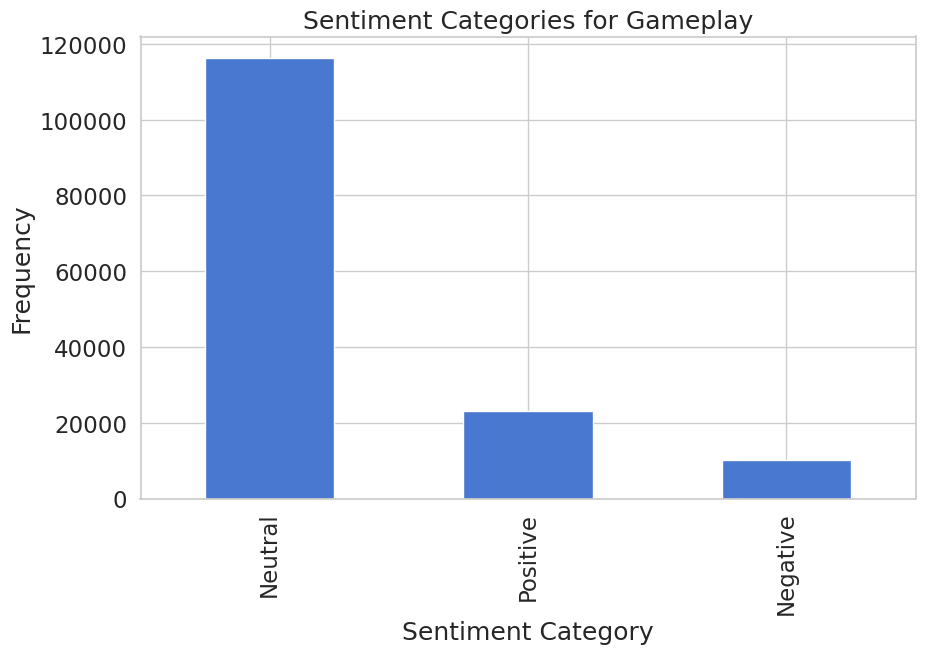

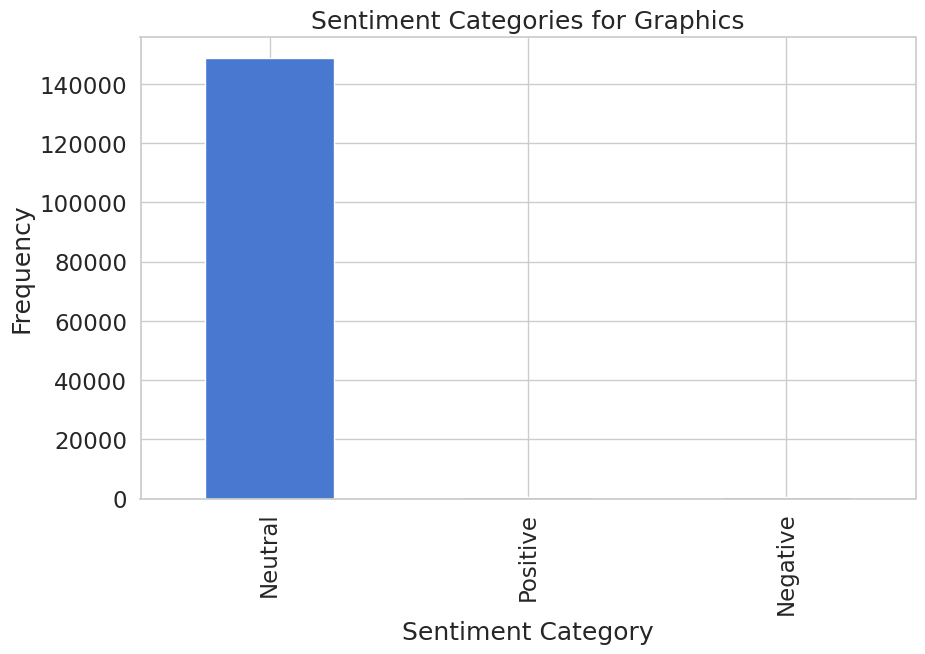

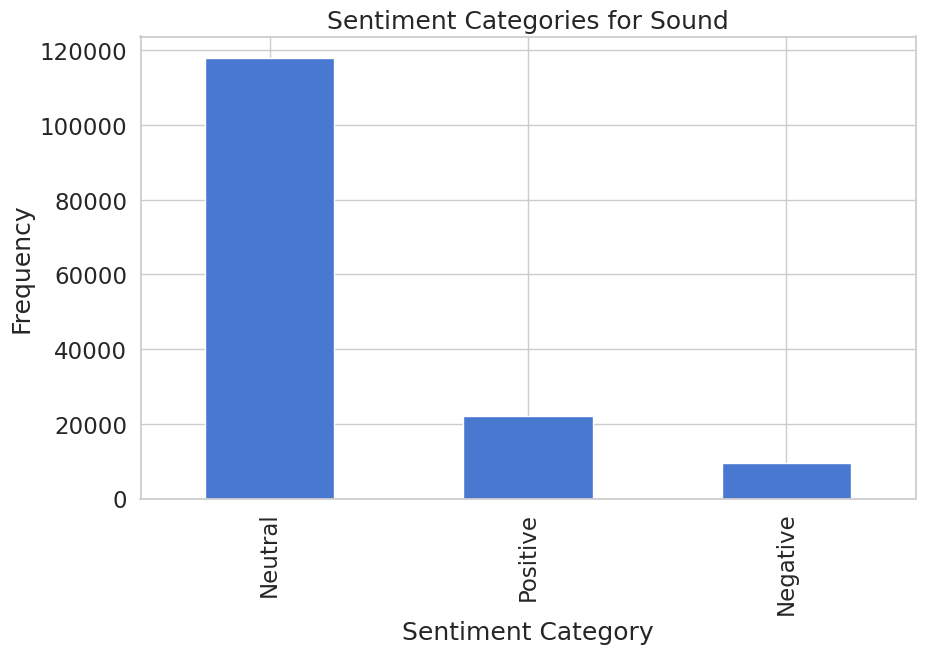

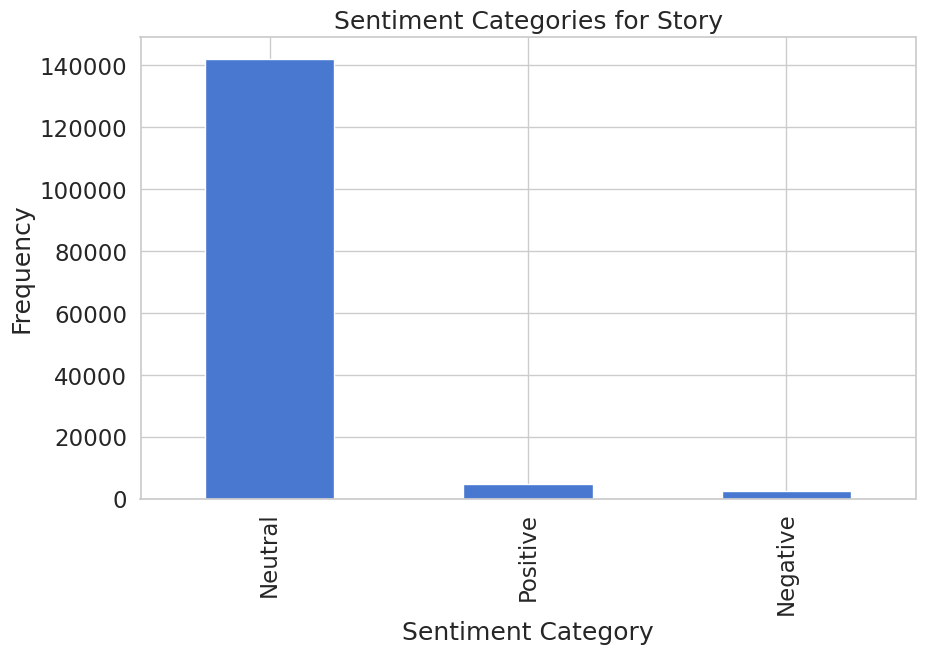

In [81]:
for aspect, _ in topic_synonyms.items():
    plt.figure(figsize=(10,6))
    df_pd[f'{aspect}_sentiment_category'].value_counts().plot(kind='bar')
    plt.title(f'Sentiment Categories for {aspect.capitalize()}')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Frequency')
    plt.show()

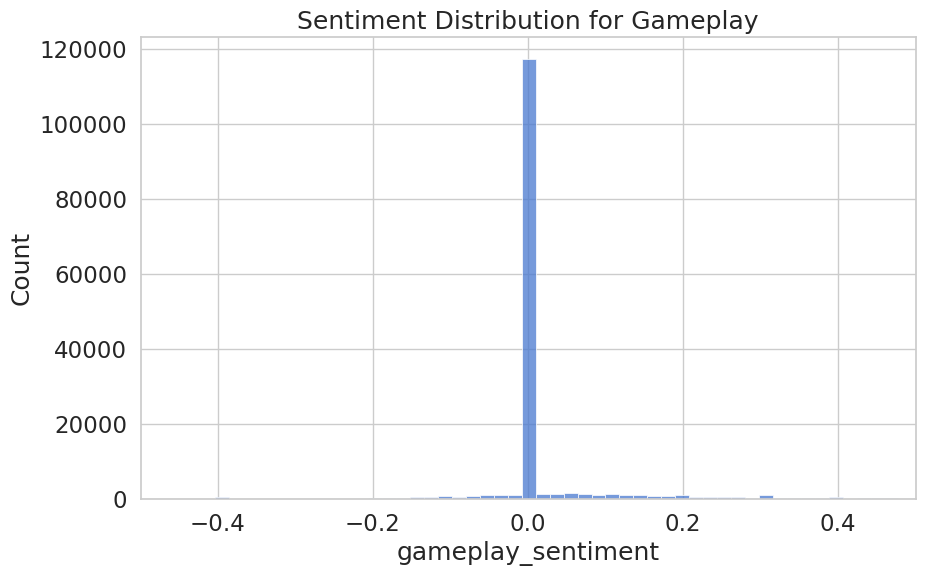

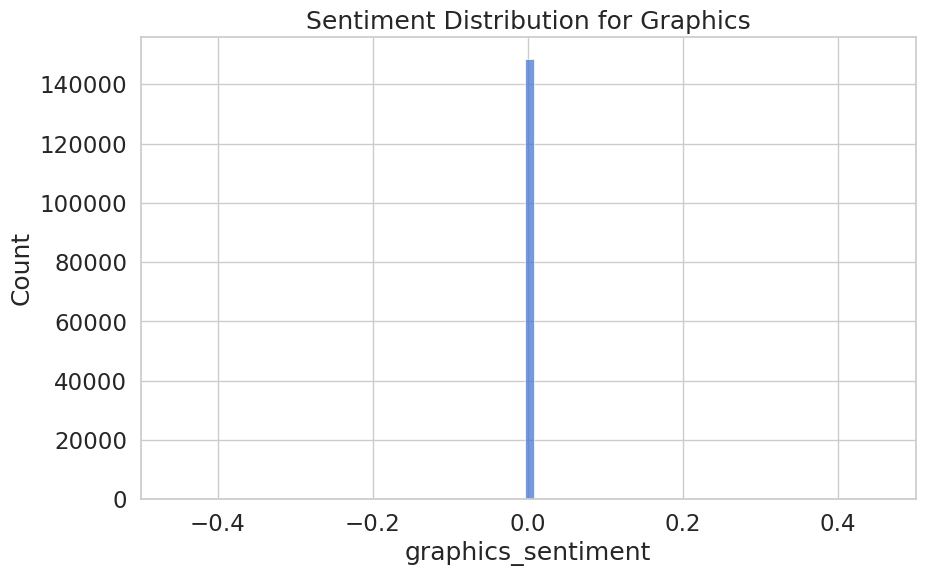

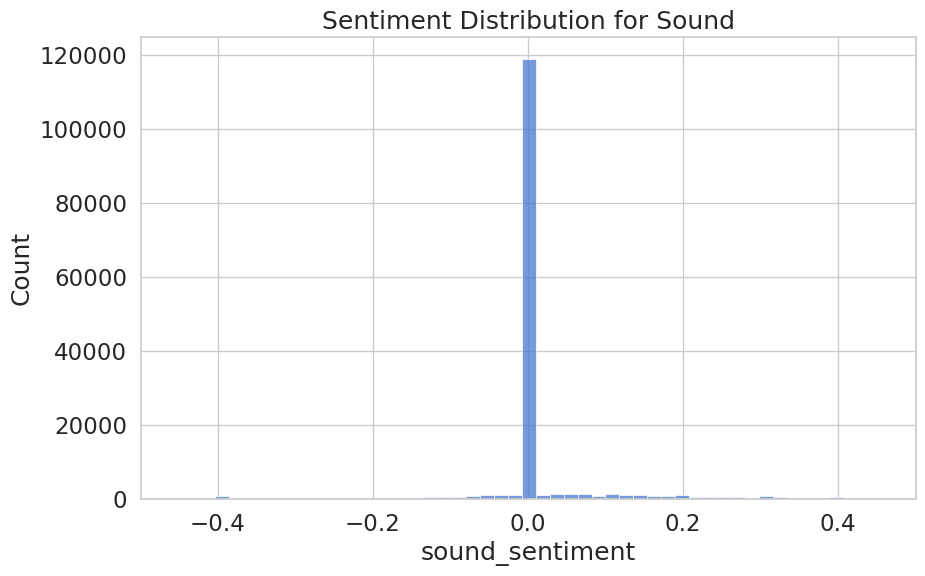

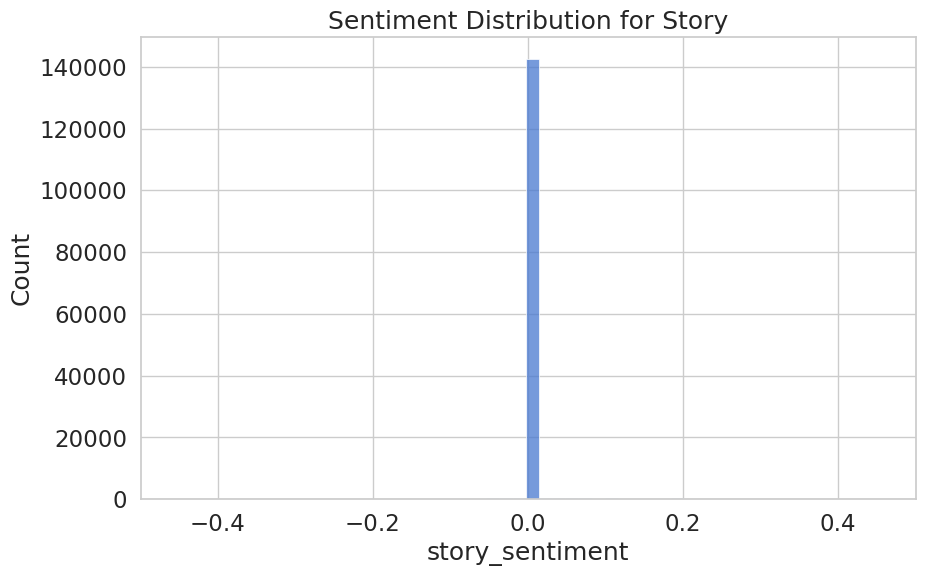

In [75]:
for aspect, _ in topic_synonyms.items():
    plt.figure(figsize=(10,6))
    ax = sns.histplot(df_pd[f'{aspect}_sentiment'], kde=False, bins=100)
    ax.set_xlim(-0.5, 0.5)  # Adjust this range to suit your needs
    plt.title(f'Sentiment Distribution for {aspect.capitalize()}')
    plt.show()

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Accuracy: \n", accuracy_score(y_test, y_pred))